# Kibővített Kálmán-szűrő (EKF)

Mielőtt rátérnénk a kibővített Kálmán-szűrő tárgyalására, foglaljuk össze a Kálmán-szűrő működését, [Welch és Bishop (2006)](http://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf) jelöléseit alkalmazva.

A lineáris rendszer modell részei:

* állapot átmeneti mátrix: $\mathbf{A}$
* kezdeti rendszer állapot és annak kovariancia mátrixa: $\mathbf{x}_0$, $\mathbf{P}_0$
* vezérlési mátrix: $\mathbf{B}$
* rendszer zaj kovariancia mátrix: $\mathbf{Q}$
* mérési mátrix: $\mathbf{H}$
* mérési zaj kovariancia mátrix: $\mathbf{R}$

A rendszer új $\hat{\mathbf{x}}_k$ állapotára vonatkozó becslést a szűrő egyenleteivel számíthatjuk ki: 

1. előző rendszer állapot és rendszer állapot kovariancia becslés: $\hat{\mathbf{x}}_{k-1}$, $\mathbf{P}_{k-1}$

2. következő időpontra vonatkozó előrejelzés

    1. rendszer állapot előrejelzése:  $ \hat{\mathbf{x}}_{k}^{-} = \mathbf{A}\hat{\mathbf{x}}_{k-1} + \mathbf{B}\mathbf{u}_{k-1} $
    
    2. rendszer állapot kovariancia előrejelzése:  $ \mathbf{P}_{k}^{-} = \mathbf{A}\mathbf{P}_{k-1}\mathbf{A}^T + \mathbf{Q} $

3. előrejelzett rendszer állapot frissítése a mérések alapján

    1. Kálmán erősítési mátrix számítása: $ \mathbf{K}_k = \mathbf{P}_k^-{} \mathbf{H}_k^T (\mathbf{H} \mathbf{P}_k^-{} \mathbf{H}^T + \mathbf{R})^{-1} $
    
    2. rendszer állapot frissítése a $\mathbf{z}_k$ mérés alapján: $\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^-{} + \mathbf{K}_k (\mathbf{z}_k - \mathbf{H}(\hat{\mathbf{x}}_k^-{})) $
    
    3. frissített rendszer állapot kovariancia mátrix számítása: $\mathbf{P}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \mathbf{P}_k^-{}$
    
Korábban már említettük, hogy egy konkrét feladat megoldása kapcsán a legnagyobb feladat a helyes rendszer modell létrehozása. A következőkben próbáljuk meg felírni a rendszer modellt egy egyszerű navigációs feladat esetében.

## Odometria kerékre szerelt kéttengelyű gyorsulásmérővel

A feladat a következő: határozzuk meg egy kerékre szerelt kéttengelyű gyorsulásmérő szenzor adatai alapján a kerék által megtett utat. Tegyük fel, hogy a kerék vízszintes talajon csúszás nélkül gördül.

A *csúszás nélkül* gördülő kerék mozgása egyenes haladásból és forgásból áll. A pillanatnyi érintkezési pont zérus sebességű, ahogy az ábráról látható:

<img src="./img/gordul1.png" width="600"/>

Az ábrán látható $r_w$ sugarú kerék O középpontjától $r_s$ távolságban rögzített kéttengelyű S gyorsulásmérő szenzor 1. tengelye a sugárra merőlegesen a pozitív forgásirányban (óramutató járásával megegyezően), 2. tengelye a sugár irányában, az O középpont felé mutat. 

<img src="./img/gordul2.png" width="300" />

A $\mathbf{g}$ nehézségi gyorsulás vektornak a szenzor tengelyirányaiba mutató összetevői:

$$a_1=-g\sin(\theta)$$
$$a_2=-g\cos(\theta)$$.

Az O középpontban $\ddot{p}$ lineáris gyorsulással haladó kerék esetében az S szenzor érzékelő tömegére ellenkező irányú gyorsulás hat az ábra szerint

<img src="./img/gordul3.png" width="300" />

melynek összetevői:

$$a_1=\ddot{p}\cos(\theta)$$
$$a_2=-\ddot{p}\sin(\theta)$$.



Végül a kerék gyorsuló forgása miatt fellép $a_1$ irányában centripetális, $a_2$ irányában centrifugális gyorsulás.

<img src="./img/gordul4.png" width="300"/>

A kerék csúszás mentes gördülése miatt a $\theta$ elfordulási szög, a $\dot\theta$ szögsebesség és a $\ddot\theta$ szöggyorsulás kapcsolatban van a megtett $p$ úttal, a $\dot{p}$ haladási sebességgel és a $\ddot{p}$ lineáris gyorsulással:

$$\theta=\frac{p}{r_w}$$
$$\dot\theta=\frac{\dot{p}}{r_w}$$
$$\ddot\theta=\frac{\ddot{p}}{r_w}$$

A szenzor tengelyei irányában fellépő gyorsulások tehát

$$a_1=-r_s \ddot\theta = -\frac{r_s}{r_w}\ddot{p}$$
$$a_2=-r_s \dot\theta^2 = -\frac{r_s}{r_w^2}\dot{p}^2$$

A szenzorra ható *teljes* gyorsulás komponensei az előzőek alapján most már felírhatók:

$$a_1=-g\sin(\frac{p}{r_w})+\ddot{p}\cos(\frac{p}{r_w})-\frac{r_s}{r_w}\ddot{p}$$
$$a_2=-g\cos(\frac{p}{r_w})-\ddot{p}\sin(\frac{p}{r_w})-\frac{r_s}{r_w^2}\dot{p}^2$$


### Állapot és mérési egyenlet

A Kálmán-szűrő egyenleteinek felírásához a rendszer $\mathbf{x}$ *állapot vektorát* a kerék helyzete, sebessége és gyorsulása adja

$$\mathbf{x} = \begin{bmatrix}
p\\ 
\dot p\\ 
\ddot p
\end{bmatrix} .$$

A $h(\mathbf{x},\mathbf{v})$ mérési függvény a mért gyorsulásokat adó függvény

$$ h(\mathbf{x},\mathbf{v}) = \begin{bmatrix}
-g\sin\left(\frac{p}{r_w}\right)+\ddot{p}\cos\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w}\ddot{p} + v_1\\ 
-g\cos\left(\frac{p}{r_w}\right)-\ddot{p}\sin\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w^2}\dot{p}^2 + v_2
\end{bmatrix} $$

ahol $\mathbf{v}=(v_1,v_2)$ jelöli a mérési zajt, amely zérus várható értékű Gauss-eloszlású valószínűségi változó.

Ez a függvény <b><span style="color:red;"> nem lineáris </span></b>, tehát az egyszerű Kálmán-szűrő nem alkalmas a feladat megoldására. Helyette a **kibővített Kálmán-szűrés**t fogjuk alkalmazni, ami nem jelent mást, mint a nem lineáris egyenletek linearizálását a mérések illetve a rendszer állapot becslés helyén.

Mielőtt erre rátérnénk, írjuk meg a mérési függvény Python kódját, hiszen szükségünk lesz rá:

In [1]:
def h(x,rs,rw):
    ## mérési egyenlet függvénye
    ## x  = állapot vektor (p,pdot,pdotdot)
    ## rs = szenzor tengelytől mért távolsága
    ## rw = kerék sugara
    g = 9.81
    h1 = -g*np.sin(x[0]/rw) + x[2]*np.cos(x[0]/rw) - x[2]*rs/rw
    h2 = -g*np.cos(x[0]/rw) - x[2]*np.sin(x[0]/rw) - (x[1])**2*rs/(rw**2)
    return np.array([h1,h2]).flatten()

Az állapot átmenet $A$ mátrixa már linearizálva van:

$$ A = \begin{bmatrix}
1 & \Delta t & \frac{1}{2}\Delta t^2 \\ 
0 & 1 & \Delta t\\ 
0 & 0 & 1
\end{bmatrix}$$

Az állapot terjedés Python függvényét tehát egyszerűen megírhatjuk:

In [2]:
def f(x,dt):
    """ állapot terjedés függvénye
     x  = állapot vektor (p,pdot,pdotdot)
     dt = időkülönbség
    """
    f1 = x[0] + x[1]*dt + 0.5*x[2]*dt**2
    f2 = x[1] + x[2]*dt
    f3 = x[2]
    return np.array([f1,f2,f3]).flatten()

## Kibővített Kálmán-szűrő (Extended Kalman Filter, EKF) összefüggései 


Abban az esetben, amikor a mérési egyenlet vagy az állapot átviteli egyenlet, vagy mindkettő nem lineáris, a kibővített Kálmán-szűrés összefüggéseire van szükségünk. 

A rendszer állapota a következő nem lineáris $f$ függvény szerint változik:

$$ x_k = f(\mathbf{x}_{k-1}, \mathbf{u}_{k-1}, \mathbf{w}_{k-1})$$

ahol $\mathbf{w}$ a rendszer zaja. A $\mathbf{z}$ mérések pedig a következő nem lineáris $h$ függvényen keresztül vannak kapcsolatban a rendszer $x$ állapotával:

$$z_k = h(\mathbf{x}_k, \mathbf{v}_k),$$

ahol $\mathbf{v}$ a mérési zaj. Természetesen általában nem ismerjük az egyes zaj komponenseket, ezért közelítőleg nélkülük számítjuk ki a rendszer állapotát és a mérési vektort:

$$ \tilde{\mathbf{x}_k} = f(\hat{\mathbf{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0})$$
$$ \tilde{\mathbf{z}_k} = h(\tilde{\mathbf{x}}_k, \mathbf{0})$$

ahol $\hat{\mathbf{x}}_{k-1}$ a rendszer előző állapotának becslése. Fontos megjegyeznünk, hogy a kibővített Kálmán-szűrő alapvető hiányossága az, hogy különböző valószínűségi változók eloszlása a nem lineáris transzformáció után már nem Gauss-féle, ezért a becslés nem is lehet optimális.

Az egyenletek linearizációja után ezeket az összefüggéseket kapjuk:

$$ \mathbf{x}_k \approx \tilde{\mathbf{x}}_k + \mathbf{A}(\mathbf{x}_{k-1} - \hat{\mathbf{x}}_{k-1}) + \mathbf{W}\mathbf{w}_{k-1}$$

$$ \mathbf{z}_k \approx \tilde{\mathbf{z}}_k + \mathbf{H}(\mathbf{x}_k - \tilde{\mathbf{x}}_{k}) + \mathbf{V}\mathbf{v}_{k},$$

ahol

* $\mathbf{x}_k$ és $\mathbf{z}_k$ a tényleges állapot és mérési vektorok,
* $\tilde{\mathbf{x}}_k$ és $\tilde{\mathbf{z}}_k$ a közelítő állapot és mérési vektorok,
* $\hat{\mathbf{x}}_{k}$ az állapot végleges becslése a $k$ időpontban,
* a $\mathbf{w}_{k}$ és $\mathbf{v}_{k}$ a folyamat és mérési zaj,
* $\mathbf{A}$ az $f$ függvény Jacobi-mátrixa az $\mathbf{x}$ szerint,
* $\mathbf{W}$ az $f$ függvény Jacobi-mátrixa az $\mathbf{w}$ szerint,
* $\mathbf{H}$ a $h$ függvény Jacobi-mátrixa az $\mathbf{x}$ szerint,
* $\mathbf{v}$ a $h$ függvény Jacobi-mátrixa az $\mathbf{v}$ szerint.

A rendszer új $\hat{\mathbf{x}}_k$ állapotára vonatkozó becslést a kibővített szűrő (EKF) egyenleteivel számíthatjuk ki: 

1. előző rendszer állapot és rendszer állapot kovariancia becslés: $\hat{\mathbf{x}}_{k-1}$, $\mathbf{P}_{k-1}$

2. következő időpontra vonatkozó előrejelzés

    1. rendszer állapot előrejelzése:  $ \hat{\mathbf{x}}_k^{-}=f(\hat{\mathbf{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0}) $
    
    2. rendszer állapot kovariancia előrejelzése:  $ \mathbf{P}_{k}^{-} = \mathbf{A}_k\mathbf{P}_{k-1}\mathbf{A}_k^T + \mathbf{W}_k\mathbf{Q}_{k-1}\mathbf{W}_k^T $

3. előrejelzett rendszer állapot frissítése a mérések alapján

    1. Kálmán erősítési mátrix számítása: $ \mathbf{K}_k = \mathbf{P}_k^-{} \mathbf{H}_k^T (\mathbf{H} \mathbf{P}_k^-{} \mathbf{H}^T + \mathbf{V}_k\mathbf{R}_{k}\mathbf{v}_k^T)^{-1} $
    
    2. rendszer állapot frissítése a $\mathbf{z}_k$ mérés alapján: $\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^-{} + \mathbf{K}_k (\mathbf{z}_k - h(\hat{\mathbf{x}}_k^{-}, \mathbf{0})) $
    
    3. frissített rendszer állapot kovariancia mátrix számítása: $\mathbf{P}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \mathbf{P}_k^-{}$
    

A konkrét feladatban a kibővített szűrő a nemlineáris mérési egyenlet **Jacobi** mátrixának felírásával valósítható meg. A mérési egyenlet $H$ Jacobi mátrixa a $h(\mathbf{x},\mathbf{v})$ mérési függvény $\mathbf{x}$ állapot vektor összetevői ($p$, $\dot{p}$, $\ddot{p}$) szerinti parciális deriváltakat tartalmazza:

$$ H = \begin{bmatrix}
-\frac{g}{r_w}\cos\left(\frac{p}{r_w}\right)-\frac{\ddot{p}}{r_w}\sin\left(\frac{p}{r_w}\right) & 0 & \cos\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w}\\ 
\frac{g}{r_w}\sin\left(\frac{p}{r_w}\right)-\frac{\ddot{p}}{r_w}\cos\left(\frac{p}{r_w}\right) & -2\frac{r_s}{r_w^2}\dot{p} & -\sin\left(\frac{p}{r_w}\right)
\end{bmatrix} .$$

A sztochasztikus modellhez felvett állapot zaj variancia $q=0.07 m/s^2$, a mért gyorsulások hiba varianciája $r_1=r_2=5 m/s^2$.

Az alábbi Python függvény számítja ki a $H$ mátrixot:

In [3]:
def H(x,rs,rw):
    ## a mérési egyenlet függvényének Jacobi-mátrixa
    ## x  = állapot vektor (p,pdot,pdotdot)
    ## rs = szenzor tengelytől mért távolsága
    ## rw = kerék sugara
    g = 9.81
    H = np.zeros((2,3))
    H[0,0] = -g/rw*np.cos(x[0]/rw) - x[2]/rw*np.sin(x[0]/rw)
    H[0,1] = 0.0
    H[0,2] = np.cos(x[0]/rw)- rs/rw
    H[1,0] = g/rw*np.sin(x[0]/rw) - x[2]/rw*np.cos(x[0]/rw)
    H[1,1] = -2*x[1]*rs/(rw**2)
    H[1,2] = -np.sin(x[0]/rw)
    return H

### Teszt gyorsulásmérő szenzor adatok

A kibővített Kálmán-szűrést [Gersdorf B., Frese U. (2013)](https://pdfs.semanticscholar.org/ab65/2f5c812b580f1c6b154161317b2bb9434655.pdf) cikkéből vett [gyorsulás adatokkal](./dat/a.txt) teszteljük. Maguk a mérési adatok számszerűen nincsenek a cikkben, viszont a PDF-ben található vektoros ábrát `LibreOffice Draw` programmal megnyitva az ábra `.odg` tömörített vektoros XML állományba menthető. Ezt az állományt `Notepad++` szerkesztőben megírt makrókkal átalakítva `Excel` állomány hozható létre, amelyben rajzi koordinátákból transzformálhatók a gyorsulás adatok az eredeti mértékegységükbe (m/s<sup>2</sup>) és a transzformált gyorsulás adatok végül ASCII állományba menthetők. 

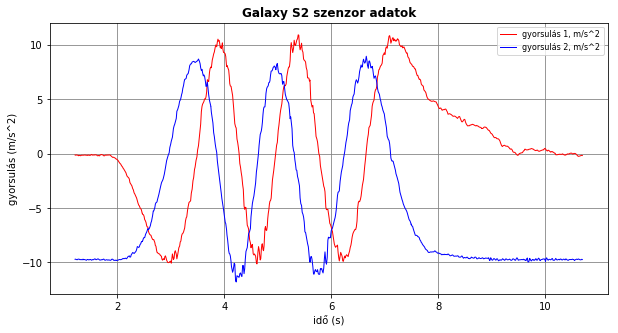

In [4]:
# -*- coding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("./dat/a.txt")
t = data[:,0]
a1= data[:,1]
a2= data[:,2]

# Rajzoljuk fel a gyorsulás adatokat
plt.figure(figsize=(10,5))
plt.plot(t,a1, 'r-', label=u'gyorsulás 1, m/s^2', lw=1)
plt.plot(t,a2, 'b-', label=u'gyorsulás 2, m/s^2', lw=1)
#plt.xlim(30,52)
plt.grid(color='grey')
plt.title(u'Galaxy S2 szenzor adatok', fontweight='bold')
plt.xlabel(u'idő (s)')
plt.ylabel(u'gyorsulás (m/s^2)')
plt.legend(loc='upper right', shadow=False, prop={'size':8}) 
plt.show()

Ahogy már láttuk, a kibővített Kálmán-szűrés egy lépésében kiszámítjuk a rendszer állapot előrejelzését majd mindig az újabb $\mathbf{z}_k$ méréssel frissítjük az állapot becslését.

előrejelzés:

$$ \hat{\mathbf{x}}_k^-{} = f(\mathbf{x}_k)$$
$$ \mathbf{P}_k^-{} = \mathbf{A} \mathbf{P}_k \mathbf{A}^T + \mathbf{Q} $$

frissítés:

$$ \mathbf{K}_k = \mathbf{P}_k^-{} \mathbf{H}_k^T (\mathbf{H} \mathbf{P}_k^-{} \mathbf{H}^T + \mathbf{R})^{-1} $$
$$ \hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^-{} + \mathbf{K}_k (\mathbf{z}_k - h(\hat{\mathbf{x}}_k^-{})) $$
$$ \mathbf{P}_k = \mathbf{P}_k^-{} - \mathbf{K}_k \mathbf{H} \mathbf{P}_k^-{} $$

A lépést megvalósító Python függvény:

In [5]:
def EKFstep(xk,Pk,A,H,Q,R,zk,dt,rs,rw):
    """a kibővített Kálmán-szűrő egy lépése
    """
    # állapot átvitel (előrejelzés)
    xkm = f(xk,dt)
    Pkm = np.dot(np.dot(A,Pk),A.T) + Q
    # újabb mérés, frissítés
    Kk = np.dot(Pkm,np.dot(H.T,np.linalg.pinv(np.dot(np.dot(H,Pkm),H.T) + R)))
    xk1 = xkm + np.dot(Kk,(zk - h(xkm,rs,rw)))
    Pk1 = Pkm - np.dot(np.dot(Kk,H),Pkm)

    return xk1,Pk1

A számítást az **EKFWheel**(t,a1,a2,q,r) függvényben programoztuk. A függvény paraméterei a következők:
*  t: a mérési időpontok vektora
* a1, a2: a gyorsulásmérő szenzor adatai a t-vel megadott időpontokban
*  q: folyamat zaj
*  r: mérési zaj

A függvény az xe mátrixban adja vissza a becsült rendszer állapotot és a $-\pi \le \theta \le \pi$ közé eső szögértékeket.

A függvény Python kódja:

In [6]:
def EKFwheel(t,a1,a2,q=0.07,r=5):
    """
    Kibővített Kálmán-szűrő kéttengelyű gyorsulásmérő szenzoros odometriához
     t - mérési időpontok vektora
     a1, a2 - mért szenzor centripetális és centrifugális gyorsulások (m/s**2)
     q - folyamat zaj varianciá (m/s**2)
     r - mérési zaj variancia (m/s**2)
    """
    # szenzor tengelytávolsága és a kerék sugara (Samsung Galaxy S2 biciklire szerelve)
    rs = 0.095  # méter
    rw = 0.35   # méter
    nt = t.shape[0]

    # állapot vektor: t, p,vel,acc,theta
    xe = np.zeros((nt,5))
    xe[:,0]=t
    # indítás
    Q = q**2*np.eye(3)
    R = r**2*np.eye(2)
    xk = np.zeros((3,1))
    Pk = q**2*np.diag([0, 0, 1])
    Ak = np.zeros((3,3))

    for i in range(1,nt):
        dt = t[i]-t[i-1]
        Hk = H(xk,rs,rw)
        A = np.eye(3)+ np.array([[0,dt,0.5*dt**2], [0,0,dt], [0,0,0]])
        zk = np.array([a1[i],a2[i]])
        # EKF lépés
        xk1,Pk1 = EKFstep(xk,Pk,A,Hk,Q,R,zk,dt,rs,rw)
        xe[i,1:4] = xk1
        xk = xk1  # állapot frissítése
        Pk = Pk1  # állapot kovariancia frissítése
        om = xk1[0]/rw  # kerék elfordulási szöge
        xe[i,4]=np.arctan2(np.sin(om),np.cos(om));  # szög: (-pi, pi)

    return xe

Ezek után elvégezhetjük a szűrést:

In [7]:
xe = EKFwheel(t,a1,a2,0.17,5.0)

Végül kirajzoltatjuk a kibővített Kálmán-szűrővel kapott eredményeket:

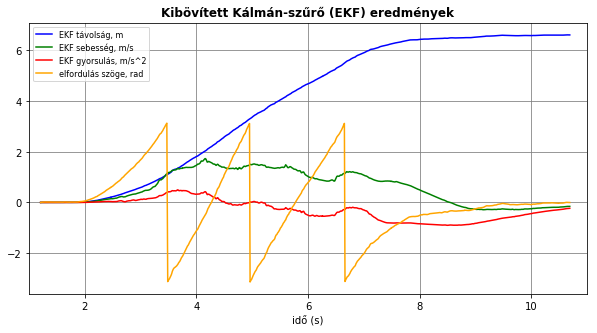

In [8]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(xe[:,0],xe[:,1], 'b-', label=u'EKF távolság, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label=u'EKF sebesség, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label=u'EKF gyorsulás, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label=u'elfordulás szöge, rad')
plt.xlim(1,11)
plt.grid(color='grey')
plt.title(u'Kibövített Kálmán-szűrő (EKF) eredmények', fontweight='bold')
plt.xlabel(u'idő (s)')
plt.legend(loc='upper left', shadow=False, prop={'size':8}) 
plt.show()

Hasonlítsuk össze ezeket az eredményeket [Gersdorf B., Frese U. (2013)](https://pdfs.semanticscholar.org/ab65/2f5c812b580f1c6b154161317b2bb9434655.pdf) említett cikkében található 5.ábrával.

<img src="img/Gersdorf5.png" width="600" />

Az eredmények elég jól megegyeznek, különösen amikor figyelembe vesszük azt, hogy a cikkben közölt eredmények a gyorsulásmérő adatain kívül giroszkóp szögsebesség ($\omega$) mérési adatokat is felhasználva készültek. Feltűnő, hogy a sebesség és a gyorsulás végül negatívvá válik, holott zérusnak kellene lennie. Sejthetjük, hogy ez a hiba a linearizáció miatt következik be.

### Vinkó Ákos gyorsulásmérő adatai


<table style="width:100%;border-style:hidden;" >
<tr>
<td style="border-right:none;">
[Vinkó Ákos](https://epito.bme.hu/vinko-akos)tól (Út és Vasútépítési Tanszék) kapott gyorsulásmérő adatokat is feldolgozzuk odometria szempontjából. Ezek az adatok egy kerékpár szabadonfutó kerekére szerelt 3 tengelyű [GCDC data logger](http://www.gcdataconcepts.com/xlr8r-1.html) [gyorsulásmérő adatai](./dat/asz.dat), azokból a 2 (érintő és sugár irányú) tengelyre vonatkozóan mért komponensek.
</td>
<td style="border-left:none;">
<img src="img/logger.png" width="450" />
</td>
</tr>
</table>

Először is olvassuk be és rajzoljuk fel a mért adatokat.

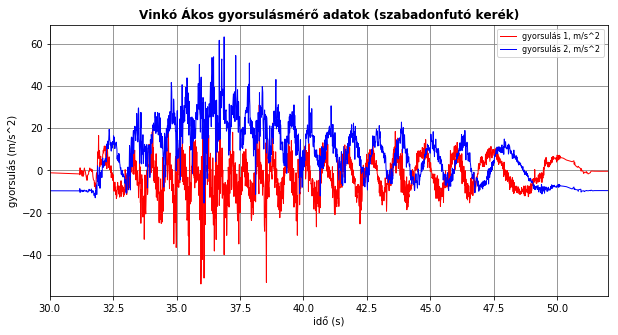

In [9]:
data = np.loadtxt("./dat/asz.dat")
t = data[:,0]
a1= data[:,1]
a2= data[:,2]

# Rajzoljuk fel a gyorsulás adatokat
plt.figure(figsize=(10,5))
plt.plot(t,a1, 'r-', label=u'gyorsulás 1, m/s^2', lw=1)
plt.plot(t,a2, 'b-', label=u'gyorsulás 2, m/s^2', lw=1)
# a számunkra érdekes rész:
plt.xlim(30,52)
plt.grid(color='grey')
plt.title(u'Vinkó Ákos gyorsulásmérő adatok (szabadonfutó kerék)', fontweight='bold')
plt.xlabel(u'idő (s)')
plt.ylabel(u'gyorsulás (m/s^2)')
plt.legend(loc='upper right', shadow=False, prop={'size':8}) 
plt.show()

Látható az, hogy ezek az adatok sokkal zajosabbak mint Gersdorf és Freese adatai. Nézzük, hogy mit tud velük kezdeni a kibővített Kálmán-szűrő.

Most a rendszer modellt kicsit módosítani kell, mert az induló helyzetben a gyorsulásmérő fázisszöge nem zérus, valamint a szenzor felhelyezési adatai és a kerék sugara is változott.

In [10]:
def EKFwheel(t,a1,a2,q=0.01,r=5):
    """
    Kibővített Kálmán-szűrő kéttengelyű gyorsulásmérő szenzoros odometriához
     t - mérési időpontok vektora
     a1, a2 - mért szenzor centripetális és centrifugális gyorsulások (m/s**2)
     q - folyamat zaj variancia (m/s**2)
     r - mérési zaj variancia (m/s**2)
     2017.02.23. BME Tóth Gy.
    """
    # szenzor tengelytávolsága és a kerék sugara
    rs = 0.165  # méter
    rw = 0.33   # méter
    nt = t.shape[0]

    # állapot vektor: t, p,vel,acc,theta
    xe = np.zeros((nt,5))
    xe[:,0]=t
    # indítás
    # föntről indul a szenzor, pi szöggel
    dist = np.pi*rw
    Qk = q**2
    Rk = r**2*np.eye(2)
    Vk = np.eye(2)
    xk = np.zeros((3,1))
    xk[0,0] = dist
    xe[0,1:4] = xk[:,0]
    xe[0,4] = np.pi
    Wk = np.array([0, 0, 1])
    Pk = Qk*np.outer(Wk,Wk)
    Ak = np.zeros((3,3))

    for i in range(1,nt):
        dt = t[i]-t[i-1]
        Hk = H(xk,rs,rw)
        Ak = np.eye(3)+ np.array([[0,dt,0.5*dt**2], [0,0,dt], [0,0,0]])
        zk = np.array([a1[i],a2[i]])
        # EKF lépés
        xk1,Pk1 = EKFstep(xk,Pk,Ak,Wk,Hk,Vk,Qk,Rk,zk,dt,rs,rw)
        xe[i,1:4] = xk1
        xk = xk1  # állapot frissítése
        Pk = Pk1  # állapot kovariancia frissítése
        om = xk1[0]/rw  # kerék elfordulási szöge
        xe[i,4]=np.arctan2(np.sin(om),np.cos(om))  # szög: (-pi, pi)

    return xe

def EKFstep(xk,Pk,Ak,Wk,Hk,Vk,Qk,Rk,zk,dt,rs,rw):
    """a kibővített Kálmán-szűrő egy lépése
       2017.02.23. BME Tóth Gy.
    """
    # állapot frissítése
    xkm = f(xk,dt)
    Pkm = np.dot(np.dot(Ak,Pk),Ak.T) + np.dot(np.dot(Wk,Qk),Wk.T)
    # újabb mérés, frissítés
    Kk = np.dot(Pkm,np.dot(Hk.T,np.linalg.pinv(np.dot(np.dot(Hk,Pkm),Hk.T) + np.dot(np.dot(Vk,Rk),Vk.T))))
    xk1 = xkm + np.dot(Kk,(zk - h(xkm,rs,rw)))
    Pk1 = Pkm - np.dot(np.dot(Kk,Hk),Pkm)

    return xk1,Pk1

A megfelelő szűréshez kisebb rendszer zaj és nagyobb mérési zaj kell. Ezen kívül az $a_2$ tengely irányát meg kell fordítani.

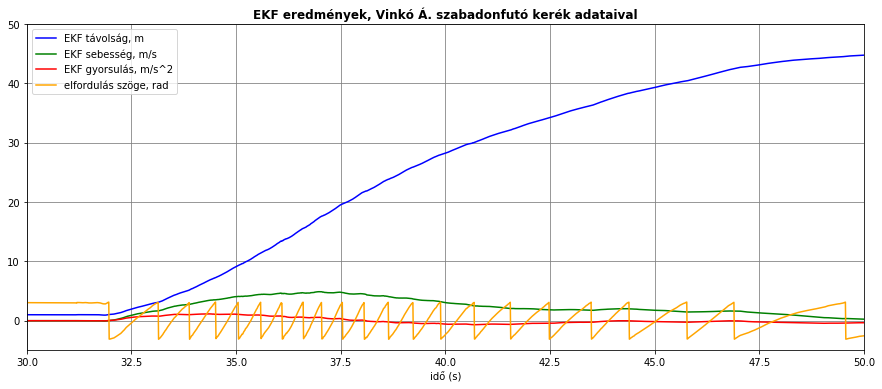

In [11]:
xe = EKFwheel(t,a1,-a2,0.01,10.0)

## eredmények felrajzolása
plt.figure(figsize=(15,6))
plt.plot(xe[:,0],xe[:,1], 'b-', label=u'EKF távolság, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label=u'EKF sebesség, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label=u'EKF gyorsulás, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label=u'elfordulás szöge, rad')
plt.xlim(30,50)
plt.ylim(-5,50)
plt.grid(color='grey')


plt.title(u'EKF eredmények, Vinkó Á. szabadonfutó kerék adataival', fontweight='bold')
plt.xlabel(u'idő (s)')
#plt.ylabel(u'távolság (m), gyorsulás (m/s^2)')
#plt.ylabel(u'sebesség (m/s), szög (rad)')
 
plt.legend(loc='upper left', shadow=False)
plt.show()

Jól látható a kezdeti gyorsítási majd a fékezési és kifutási szakasz.